In [1]:
import numpy as np
import pandas as pd
import h5py
import ast

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate

%matplotlib inline
sns.set(color_codes=True)

dfOri = {}
eventArg  = {}
eventName = {}
eventlog  = {}
event = {}

path = '../datasets/'
key = '/events/'

fname = [
    'VRAcuityExp_2017-07-13_14-39-17_VR-4A_NIC',
    'VRAcuityExp_2017-07-13_15-05-16_VR-2B_NIC',
    'VRAcuityExp_2017-07-13_15-19-09_VR-2A_EDU',
    'VRAcuityExp_2017-07-13_15-38-34_VR-1A_NIC',
    'VRAcuityExp_2017-07-13_15-53-40_VR-1B_NIC',
    'VRAcuityExp_2017-07-13_16-11-46_VR-3A_NIC',
    'VRAcuityExp_2017-07-13_16-27-08_VR-3A_NIC',
    'VRAcuityExp_2017-07-13_17-09-07_VR-5A_NIC', ]


for i, x in enumerate(fname):
    eventlog[i]  = pd.read_hdf(path+x+'.h5', key+'eventlog')      

    file    = h5py.File(path+x+'.h5', 'r')
    eventArg[i]  = file[key]['eventArguments']
    eventName[i] = file[key]['eventNames']

    
# loading original files - for full time event data
key = '/preprocessed/Rigid Body/Rat/Orientation'
path = "../datasets/"

for i, x in enumerate(fname):
    dfOri[i] = pd.read_hdf(path+fname[i]+'.h5', key)


## Loading from data frame
Loand b format, decode to string ,in string find 'attr' key to cut only following part of the string. From string build dictrionaries. Split dictionaries into 3 parts: Visibility, Speed, Duration. Merge Speed and Visibility into one dataset as separate columns. Fill in the DF with missing values in between logged ones, to create fluent dataflow. 

In [2]:
def make_dict(event):
    eventD = {}
    for i in range(0, len(event)-1):
        # change to string in proper format
        str_dict = event[i].decode('UTF-8').replace('\'', '\"')
        # find location of "attr"
        n = str_dict.find('"attr"')

        if n != -1:
            str_dict = str_dict='{' + str_dict[n:]
            dictionary = ast.literal_eval(str_dict) 
            dictionary [dictionary['attr'] ] = dictionary.pop('value')
            del dictionary['attr']
        else:
            dictionary = ast.literal_eval(str_dict)
        eventD[i] = dictionary
    return eventD


# cleaning event arguments values
eventA = {}
for i, str_dict in enumerate(fname):
    eventA[i] = make_dict(eventArg[i])

#for i in range(0, len(eventA[0])):
#    print(eventA[0][i])
#print(eventlog[0])


In [3]:
# split into 3 dictionaries 
eventVis = {}
eventSpe = {}
eventDur = {}
    
j, m, n = 0, 0, 0
x = eventA[0]

for i in range(0,len(x)-1):
    k = list(x[i].keys())[0]
    if   k == 'visible':
        eventVis[m] = {'visible':x[i]['visible'], 'i':i}
        m += 1
    elif k == 'speed':
        eventSpe[n] = {'speed':x[i]['speed'], 'i':i}
        n += 1
    elif k == 'duration':
        eventDur[j] = {'duration':x[i]['duration'], 'i':i}
        j += 1
        
DFVis = pd.DataFrame.from_dict(eventVis, orient='index')
DFSpe = pd.DataFrame.from_dict(eventSpe, orient='index')
DFDur = pd.DataFrame.from_dict(eventDur, orient='index')

In [4]:
# create new df for merge
def index_df(df):
    p = len(df.index)
    l = df.i[p-1]
    dfOut = df.set_index('i')
    dfOut = dfOut.reindex(range(0, l+1))
    dfOut.fillna(method='pad', inplace=True)
    return dfOut

DFV = index_df(DFVis)
DFS = index_df(DFSpe)
DFD = index_df(DFDur)


In [5]:
df = pd.concat([eventlog[0], DFV.visible], axis=1)
df = pd.concat([df         , DFS.speed]  , axis=1)
#df = pd.concat([df         , DFD.duration]  , axis=1)
df.fillna(method='pad', inplace=True)
df.fillna(0, inplace=True)


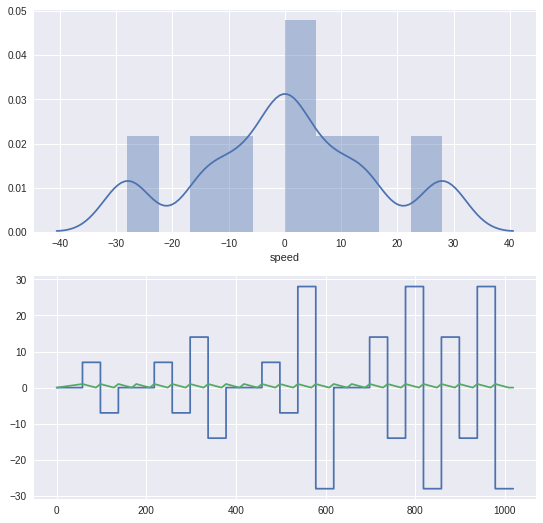

In [6]:

# grid velocity plots for one experiment
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

sns.distplot(df.speed, ax=ax1)
ax2.plot    (df.Time, df.speed)
ax2.plot    (df.Time, df.visible)

## Applying for all events


In [7]:
# split into 3 dictionaries
DFVis = {}
DFSpe = {}
DFDur = {}

for i in range(0, len(fname)):
    eventVis = {}
    eventSpe = {}
    eventDur = {}

    x = eventA[i]
    j, m, n = 0, 0, 0
    #print(x, i)
    for ii in range(0, len(x)-1):
        k = list(x[ii].keys())[0]
        if   k == 'visible':
            eventVis[m] = {'visible':x[ii]['visible'], 'i':ii}
            m += 1
        elif k == 'speed':
            eventSpe[n] = {'speed':x[ii]['speed'], 'i':ii}
            n += 1
        elif k == 'duration':
            eventDur[j] = {'duration':x[ii]['duration'], 'i':ii}
            j += 1

    DFVis[i] = pd.DataFrame.from_dict(eventVis, orient='index')
    DFSpe[i] = pd.DataFrame.from_dict(eventSpe, orient='index')
    DFDur[i] = pd.DataFrame.from_dict(eventDur, orient='index')

#print(DFVis[1])
#print(DFSpe[1])
#print(DFDur[1])

In [8]:
DFV = {}
DFS = {}

for i in range(0, len(fname)):
    DFV[i] = index_df2(DFVis[i])
    DFS[i] = index_df2(DFSpe[i])

# merging into one table of df
df = {}
for i in range(0, len(fname)):
    #print(df[i])    
    df[i] = pd.concat([eventlog[i], DFV[i].visible], axis=1)
    df[i] = pd.concat([df[i]      , DFS[i].speed]  , axis=1)
    
    #b, c = df[i].iloc[0].copy(), df[i].iloc[1].copy()
    #df[i].iloc[0], df[i].iloc[1] = c, b
    #df[i] = df[i].shift(-1).dropna()
    df[i].fillna(method='pad', inplace=True)   
    df[i].fillna(0, inplace=True)


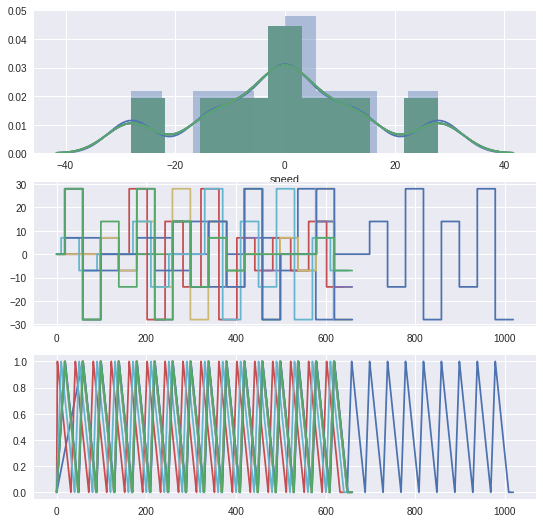

In [9]:
# grid velocity plots for all experiments
fig = plt.figure(figsize=(9,9))

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

for i in range(0, len(fname)):
    sns.distplot(df[i].speed, ax=ax1)
    ax2.plot    (df[i].Time , df[i].speed)
    ax3.plot    (df[i].Time , df[i].visible)

## Filling in values between logged ones

In [10]:
# creation of all time data series with events - for all experminets - filling in the blanks
ii = 0
dfM = {}
for ii, x in enumerate(fname):
    df1 = df[ii].dropna()
    df1.drop({'Time'}, axis=1, inplace=True)

    dfM[ii] = pd.merge(dfOri[ii], df1, on='Frame', how='left')
    dfM[ii].drop({'X', 'Y', 'Z'}, axis=1, inplace=True)

    dfM[ii].fillna(method='ffill', inplace=True)


VRAcuityExp_2017-07-13_14-39-17_VR-4A_NIC
         Frame         Time  MotiveExpTimeSecs  visible  speed
0            0     0.000000           0.000000    False    0.0
1            0     0.000000           0.000000    False    0.0
2            1     0.004167           0.000000    False    0.0
3            2     0.008333           0.000000    False    0.0
4            3     0.012500           0.000000    False    0.0
5            4     0.016667           0.000000    False    0.0
6            5     0.020833           0.000000    False    0.0
7            6     0.025000           0.000000    False    0.0
8            7     0.029167           0.000000    False    0.0
9            8     0.033333           0.000000    False    0.0
10           9     0.037500           0.000000    False    0.0
11          10     0.041667           0.000000    False    0.0
12          11     0.045833           0.000000    False    0.0
13          12     0.050000           0.000000    False    0.0
14          1

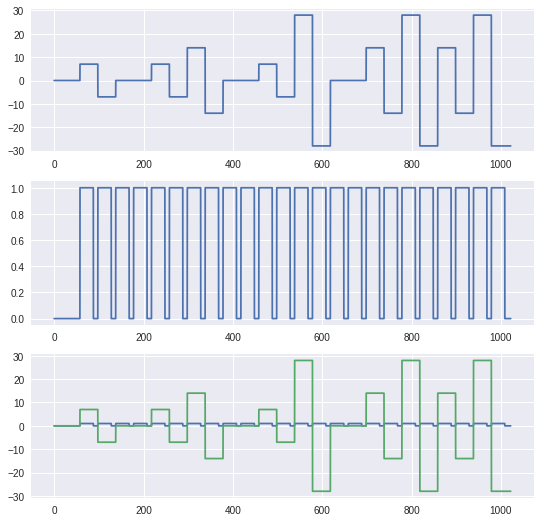

In [20]:
m = 0
pd.set_option('display.max_rows', 20000)
print(fname[m])
#print(dfM[m])

DF = dfM[m]

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(DF.Time, DF.speed)
ax2.plot(DF.Time, DF.visible)
ax3.plot(DF.Time, DF.visible, DF.Time, DF.speed)

print(DF)FRameF

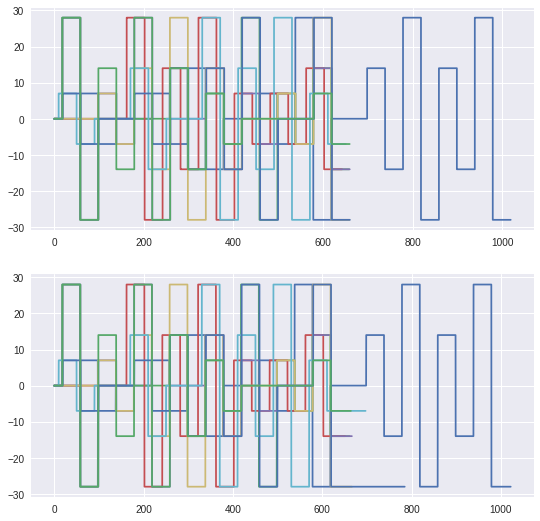

In [12]:

fig = plt.figure(figsize=(9,9))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for i in range(0, len(fname)):
    ax2.plot(dfM[i].Time, dfM[i].speed)
    ax1.plot(df[i].Time , df[i].speed)
    

In [13]:
# SAVING DATA TO FILES
path = '../datasets/analysis/'

for i, x in enumerate(fname):
    dfM[i].to_hdf(path+x+'_event.h5', 'Event', table=True)